In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
import tensorflow as tf

# path to the model weights files.
weights_path = '../keras/examples/vgg16_weights.h5'
top_model_weights_path = 'weights/fc_model.h5'
# dimensions of our images.
img_width, img_height = 216, 384

In [2]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(    
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #zoom_range=0.15,
    #shear_range=0.15,
    #rotation_range = 40,
    #brightness_range = (0.05, 0.2),
    #validation_split=0.2,
    #horizontal_flip = True,

    #preprocessing_function=additional_augmenation,
)

valgen = tf.keras.preprocessing.image.ImageDataGenerator(    
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #zoom_range=0.15,
    #shear_range=0.15,
    #rotation_range = 40,
    #brightness_range = (0.05, 0.2),
    #validation_split=0.2,
    #horizontal_flip = True,

    #preprocessing_function=additional_augmenation,
)

In [3]:
class_names = ['brak', 'wada banderoli', 'wada nakretki', 'Ok nakrętka i banderola']

In [4]:
my_seed = 11123

#train_generator = datagen.flow_from_directory('processed_dataset/nowy', batch_size=32, class_mode='categorical', seed = 123, subset='training', classes=class_names, shuffle=True)
train_generator = datagen.flow_from_directory('processed', (img_height, img_width), batch_size=32, class_mode='categorical', seed = my_seed, subset='training', classes=class_names, shuffle=True)
val_generator = valgen.flow_from_directory('dataset/dziala testy', (img_height, img_width), batch_size=32, class_mode='categorical', seed = my_seed, subset='training', classes=class_names, shuffle=True)

Found 820 images belonging to 4 classes.
Found 40 images belonging to 4 classes.


In [5]:
from collections import Counter

print("Training")
print(train_generator.class_indices)
print(Counter(train_generator.classes))
print("Validation")
print(val_generator.class_indices)
print(Counter(val_generator.classes))

num_classes = len(class_names)

Training
{'brak': 0, 'wada banderoli': 1, 'wada nakretki': 2, 'Ok nakrętka i banderola': 3}
Counter({1: 220, 0: 200, 2: 200, 3: 200})
Validation
{'brak': 0, 'wada banderoli': 1, 'wada nakretki': 2, 'Ok nakrętka i banderola': 3}
Counter({0: 10, 1: 10, 2: 10, 3: 10})


In [6]:
model = applications.vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


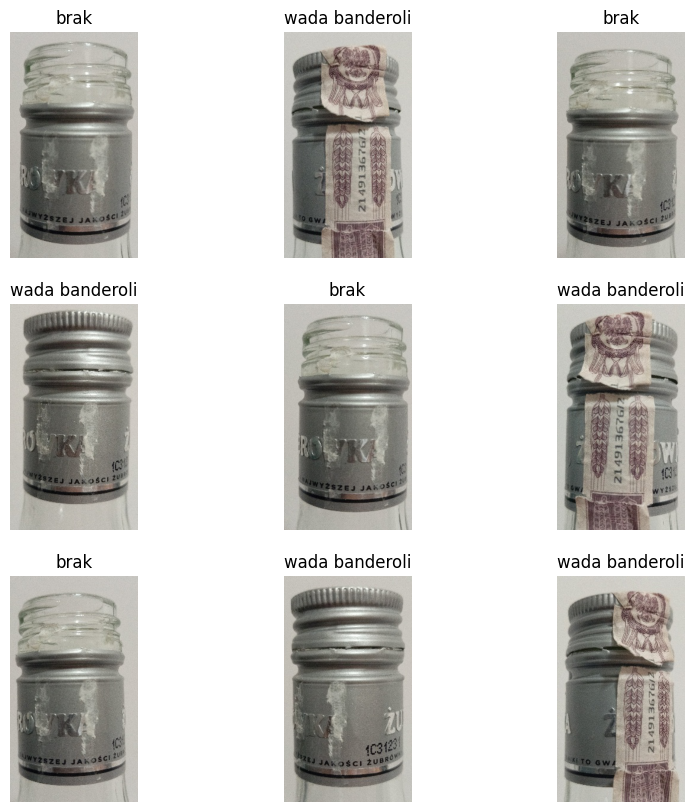

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))

for gen in range(3):
    x,y = train_generator.next()

    for i in range(3):
        ax = plt.subplot(3, 3, gen * 3 + i + 1)
        plt.imshow(x[i].astype("uint8"))
        plt.title(class_names[np.argmax(y[i])])
        plt.axis("off")

plt.show()

In [8]:
from keras.layers import Input
from keras.models import Model
# build a classifier model to put on top of the convolutional model

input_tensor = Input(shape=(img_height, img_width,3))
#input_tensor = Input(shape=(150,150,3))
base_model = applications.vgg16.VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)

top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(num_classes, activation='softmax'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
#top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model = Model(base_model.input, top_model(base_model.output))

In [9]:
base_model.input

<KerasTensor: shape=(None, 384, 216, 3) dtype=float32 (created by layer 'input_2')>

In [10]:
base_model.output

<KerasTensor: shape=(None, 12, 6, 512) dtype=float32 (created by layer 'block5_pool')>

In [11]:
new_model = Sequential()
for l in base_model.layers:
    new_model.add(l)


for l in top_model.layers:
    new_model.add(l)
# CONCATENATE THE TWO MODELS
print(new_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 384, 216, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 384, 216, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 192, 108, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 192, 108, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 192, 108, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 96, 54, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 96, 54, 256)      

In [12]:
len(base_model.layers)

19

In [13]:
for layer in new_model.layers[:len(base_model.layers) - 1]:
    layer.trainable = False

In [18]:
new_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics =['mse', 'accuracy'])

In [19]:
epochs = 10

my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='vgg_nowy.{epoch:02d}-{val_loss:.2f}.h5'),
]

history=new_model.fit(train_generator, epochs=epochs, steps_per_epoch = 5, callbacks=my_callbacks, validation_data=val_generator)

Epoch 1/10
5/5 [==============================] - 60s 13s/step - loss: 7.2888 - mse: 0.0498 - accuracy: 0.9000 - val_loss: 0.7281 - val_mse: 0.0125 - val_accuracy: 0.9750
Epoch 2/10
5/5 [==============================] - 66s 14s/step - loss: 1.4320 - mse: 0.0104 - accuracy: 0.9750 - val_loss: 0.6753 - val_mse: 0.0125 - val_accuracy: 0.9750
Epoch 3/10
5/5 [==============================] - 84s 19s/step - loss: 0.7764 - mse: 0.0063 - accuracy: 0.9875 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
5/5 [==============================] - 75s 16s/step - loss: 7.4506e-10 - mse: 4.1951e-17 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
3/5 [=================>............] - ETA: 18s - loss: 1.7807 - mse: 0.0156 - accuracy: 0.9688

KeyboardInterrupt: 

In [26]:
new_model.save('vgg16_model_4.h5')